In [1]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

1.13.0+cu116
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 41.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 33.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.4/512.4 KB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.2/280.2 KB 29.9 MB/s eta 0:00:00


In [2]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool
import matplotlib.pyplot as plt
import torch
from torch_geometric.datasets import TUDataset
import numpy as np
from termcolor import colored
from torchsummary import summary
from torch.autograd import Variable
from keras import backend as K
from statistics import mean
from operator import add
from sklearn import metrics
from copy import deepcopy
#from captum.attr import Saliency
from scipy.spatial.distance import hamming
from itertools import zip_longest
import csv
from time import perf_counter
import csv
import torch.nn as nn
import torch_geometric.nn as gnn
from torch import Tensor
from torch_geometric.typing import OptPairTensor, Adj, OptTensor, Size
from typing import Callable, Union, Tuple
from torch_sparse import SparseTensor
from torch.nn.modules import activation
from time import perf_counter
import random
import pandas

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
Explainability_name = 'CAM'
Task_name = 'Graph Classification'
checkpoint_directory_Classifier = "/content/drive/My Drive/Explainability Methods/" + str(Explainability_name) + " on " + str(Task_name) + "/Model/model_classifier.pt"

In [5]:
dataset = TUDataset(root='data/TUDataset', name='MUTAG')

print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')


data = dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: MUTAG(188):
Number of graphs: 188
Number of features: 7
Number of classes: 2

Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])
Number of nodes: 17
Number of edges: 38
Average node degree: 2.24
Has isolated nodes: False
Has self-loops: False
Is undirected: True


Extracting data/TUDataset/MUTAG/MUTAG.zip
Processing...
Done!


In [6]:
df = pandas.read_csv("/content/drive/My Drive/Explainability Methods/Train and Test Indexes on Graph Classification/Experimental Results/train_test_indexes.csv")

read_training_list_indexes__ = df['Train Indexes']
read_test_list_indexes__ = df['Test Indexes']
read_test_list_indexes__ = read_test_list_indexes__.dropna()
read_test_list_indexes = []
read_training_list_indexes = []
for element in read_test_list_indexes__:
  read_test_list_indexes.append(int(element))
for element in read_training_list_indexes__:
  read_training_list_indexes.append(int(element))


print(read_training_list_indexes)
print(read_test_list_indexes)

[51, 142, 143, 10, 4, 141, 125, 23, 3, 79, 28, 117, 136, 156, 83, 128, 109, 70, 31, 58, 7, 148, 14, 187, 20, 162, 123, 13, 91, 185, 169, 102, 32, 55, 119, 25, 161, 175, 52, 121, 152, 108, 113, 65, 39, 103, 131, 42, 166, 110, 160, 68, 90, 89, 64, 172, 159, 72, 170, 18, 122, 29, 179, 49, 171, 178, 9, 74, 96, 48, 181, 127, 126, 87, 12, 163, 88, 53, 94, 146, 5, 158, 16, 67, 6, 59, 164, 151, 34, 47, 54, 46, 100, 112, 93, 182, 66, 106, 124, 19, 186, 133, 45, 15, 40, 167, 174, 98, 105, 153, 61, 63, 132, 116, 43, 80, 33, 147, 165, 69, 135, 86, 76, 57, 173, 115, 138, 140, 134, 180, 95, 22, 38, 41, 24, 120, 145, 26, 21, 50, 176, 107, 78, 17, 85, 154, 60, 92, 184, 129]
[0, 1, 2, 8, 11, 27, 30, 35, 36, 37, 44, 56, 62, 71, 73, 75, 77, 81, 82, 84, 97, 99, 101, 104, 111, 114, 118, 130, 137, 139, 144, 149, 150, 155, 157, 168, 177, 183]


In [7]:
torch.manual_seed(123456)
#dataset = dataset.shuffle()

#train_dataset = dataset[:150]
#test_dataset = dataset[150:]
train_dataset = []
test_dataset = []
for index in read_training_list_indexes:
  train_dataset.append(dataset[index])
for index in read_test_list_indexes:
  test_dataset.append(dataset[index])


print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 150
Number of test graphs: 38


# **Batching Data by DataLoader**

In [8]:
from torch_geometric.loader import DataLoader

BATCH_SIZE = 64
size_of_hidden_layers = 7

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# **Model Designing**

In [ ]:
#class GCN(torch.nn.Module):
#    def __init__(self, hidden_channels):
#        super(GCN, self).__init__()
#        torch.manual_seed(12345)
#        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
#        self.conv2 = GCNConv(hidden_channels, hidden_channels)
#        #self.conv3 = GCNConv(hidden_channels, hidden_channels)
#        self.lin = Linear(hidden_channels, dataset.num_classes)
#
#    def forward(self, x, edge_index, batch):
#        # 1. Obtain node embeddings 
#        x = self.conv1(x, edge_index)
#        x = torch.nn.functional.elu(x)
#
#        x = self.conv2(x, edge_index)
#        x_last_Conv = torch.nn.functional.elu(x)
#
#        #x = self.conv3(x, edge_index)
#        #x = torch.nn.functional.elu(x)
#
#        # 2. Readout layer
#        x_GAP = global_mean_pool(x_last_Conv, batch)  # [batch_size, hidden_channels]
#
#        # 3. Apply a final classifier
#        #x_GAP = F.dropout(x_GAP, p=0.5, training=self.training)
#        x_final = self.lin(x_GAP)
#        x_Final = F.softmax(x_final, dim=1)
#        
#        return x_last_Conv, x_GAP, x_Final
#
#
#CAM_model_GCN = GCN(hidden_channels=size_of_hidden_layers)
#print(CAM_model_GCN)

In [9]:
class GNNPool(nn.Module):
    def __init__(self):
        super().__init__()

In [10]:
class GlobalMeanPool(GNNPool):

    def __init__(self):
        super().__init__()

    def forward(self, x, batch):
        return gnn.global_mean_pool(x, batch)

In [11]:
class IdenticalPool(GNNPool):

    def __init__(self):
        super().__init__()

    def forward(self, x, batch):
        return x

In [12]:
class GNNBasic(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def arguments_read(self, *args, **kwargs):

        data: Batch = kwargs.get('data') or None

        if not data:
            if not args:
                assert 'x' in kwargs
                assert 'edge_index' in kwargs
                x, edge_index = kwargs['x'], kwargs['edge_index'],
                batch = kwargs.get('batch')
                if batch is None:
                    batch = torch.zeros(kwargs['x'].shape[0], dtype=torch.int64, device=x.device)
            elif len(args) == 2:
                x, edge_index = args[0], args[1]
                batch = torch.zeros(args[0].shape[0], dtype=torch.int64, device=x.device)
            elif len(args) == 3:
                x, edge_index, batch = args[0], args[1], args[2]
            else:
                raise ValueError(f"forward's args should take 2 or 3 arguments but got {len(args)}")
        else:
            x, edge_index, batch = data.x, data.edge_index, data.batch

        return x, edge_index, batch


In [13]:
class GCNConv(gnn.GCNConv):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.edge_weight = None
        self.weight = nn.Parameter(self.lin.weight.data.T.clone().detach())

    def forward(self, x: Tensor, edge_index: Adj,
                edge_weight: OptTensor = None) -> Tensor:
        """"""

        if self.normalize and edge_weight is None:
            if isinstance(edge_index, Tensor):
                cache = self._cached_edge_index
                if cache is None:
                    edge_index, edge_weight = gnn.conv.gcn_conv.gcn_norm(  # yapf: disable
                        edge_index, edge_weight, x.size(self.node_dim),
                        self.improved, self.add_self_loops, dtype=x.dtype)
                    if self.cached:
                        self._cached_edge_index = (edge_index, edge_weight)
                else:
                    edge_index, edge_weight = cache[0], cache[1]

            elif isinstance(edge_index, SparseTensor):
                cache = self._cached_adj_t
                if cache is None:
                    edge_index = gnn.conv.gcn_conv.gcn_norm(  # yapf: disable
                        edge_index, edge_weight, x.size(self.node_dim),
                        self.improved, self.add_self_loops, dtype=x.dtype)
                    if self.cached:
                        self._cached_adj_t = edge_index
                else:
                    edge_index = cache

        edge_weight.requires_grad_(True)

        x = torch.matmul(x, self.weight)

        out = self.propagate(edge_index, x=x, edge_weight=edge_weight,
                             size=None)

        if self.bias is not None:
            out += self.bias

        self.edge_weight = edge_weight

        return out

    def propagate(self, edge_index: Adj, size: Size = None, **kwargs):
        size = self.__check_input__(edge_index, size)

        # Run "fused" message and aggregation (if applicable).
        if (isinstance(edge_index, SparseTensor) and self.fuse
                and not self._explain):
            coll_dict = self.__collect__(self.__fused_user_args__, edge_index,
                                         size, kwargs)

            msg_aggr_kwargs = self.inspector.distribute(
                'message_and_aggregate', coll_dict)
            out = self.message_and_aggregate(edge_index, **msg_aggr_kwargs)

            update_kwargs = self.inspector.distribute('update', coll_dict)
            return self.update(out, **update_kwargs)

        elif isinstance(edge_index, Tensor) or not self.fuse:
            coll_dict = self.__collect__(self.__user_args__, edge_index, size,
                                         kwargs)

            msg_kwargs = self.inspector.distribute('message', coll_dict)
            out = self.message(**msg_kwargs)

            if self._explain:
                edge_mask = self.__edge_mask__
                if out.size(self.node_dim) != edge_mask.size(0):
                    loop = edge_mask.new_ones(size[0])
                    edge_mask = torch.cat([edge_mask, loop], dim=0)
                assert out.size(self.node_dim) == edge_mask.size(0)
                out = out * edge_mask.view([-1] + [1] * (out.dim() - 1))

            aggr_kwargs = self.inspector.distribute('aggregate', coll_dict)
            out = self.aggregate(out, **aggr_kwargs)

            update_kwargs = self.inspector.distribute('update', coll_dict)
            return self.update(out, **update_kwargs)


In [14]:
class GCN_2l_Model(GNNBasic):

    def __init__(self, model_level, dim_node, dim_hidden, dim_output):
        super().__init__()
        num_layer = 2

        self.gconv1 = GCNConv(dim_node, dim_hidden, bias=False)
        #self.elu1 = nn.functional.elu() 
        
        self.gconv2 = GCNConv(dim_hidden, dim_hidden, bias=False)
        #self.elu2 = nn.functional.elu()

        if model_level == 'node':
            self.readout = IdenticalPool()
        else:
            self.readout = GlobalMeanPool()

        self.ffn = nn.Linear(dim_hidden, dim_output, bias=False)

        self.dropout = nn.Dropout()

    def forward(self, *args, **kwargs) -> torch.Tensor:
        """
        :param Required[data]: Batch - input data
        :return:
        """
        x, edge_index, batch = self.arguments_read(*args, **kwargs)

        post_conv1 = nn.functional.elu(self.gconv1(x, edge_index))
        #out_readout1 = self.readout(post_conv1, batch)
        #print(np.shape(out_readout1))
        post_conv2 = nn.functional.elu(self.gconv2(post_conv1, edge_index))
        out_readout = self.readout(post_conv2, batch)

        #print(np.shape(out_readout))
        out = self.ffn(out_readout)

        return post_conv1, post_conv2, out_readout, out

    def get_emb(self, *args, **kwargs) -> torch.Tensor:
        x, edge_index, batch = self.arguments_read(*args, **kwargs)
        
        post_conv1 = self.relu1(self.gconv1(x, edge_index))
        post_conv2 = self.relu2(self.gconv2(post_conv1, edge_index))
            
        return post_conv2

In [15]:
feat_size = train_dataset[0].x.shape[1]
CAM_model_GCN = GCN_2l_Model(model_level='graph', dim_node=feat_size, dim_hidden=feat_size, dim_output=dataset.num_classes)
CAM_model_GCN.eval()

GCN_2l_Model(
  (gconv1): GCNConv(7, 7)
  (gconv2): GCNConv(7, 7)
  (readout): GlobalMeanPool()
  (ffn): Linear(in_features=7, out_features=2, bias=False)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [16]:
CAM_optimizer = torch.optim.Adam(CAM_model_GCN.parameters(), lr=0.001)

In [17]:
criterion = torch.nn.CrossEntropyLoss()
def loss_calculations(preds, gtruth):
  loss_per_epoch = criterion(preds, gtruth)
  return loss_per_epoch


In [18]:
def loading_model(load_index):
  CAM_model_GCN = GCN_2l_Model(hidden_channels=size_of_hidden_layers)
  CAM_optimizer = torch.optim.Adam(params = CAM_model_GCN.parameters(), lr=0.001)
  checkpoint = torch.load("/content/drive/My Drive/Explainability Methods/"+str(Explainability_name)+" on " + str(Task_name) + "/Model/" + str(Explainability_name) + " on " + str(Task_name) + " classifier model_" + str(epoch + load_index + 1)+".pt")
  CAM_model_GCN.load_state_dict(checkpoint['model_state_dict'])
  CAM_optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  epoch = checkpoint['epoch']
  loss = checkpoint['loss']


  return CAM_model_GCN, CAM_optimizer, epoch

In [19]:
def visualize_losses(cam_losses, epoch_history):
  cam_losses_list = torch.stack(cam_losses).cpu().detach().numpy()

  fig = plt.figure(figsize=(27,20))

  ax = plt.subplot2grid((3, 1), (0, 0), colspan=1)
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title("CAM Model Loss in Epoch: " + str(epoch_history))

  ax.plot(cam_losses_list, color='r')

  plt.savefig('/content/drive/My Drive/Explainability Methods/'+str(Explainability_name)+' on ' + str(Task_name) + '/Experimental Results/'+'Loss_til_epoch_{:04d}.png'.format(epoch_history))
  plt.show()  




# **Traning Configurations**

In [20]:
def train_step():
  CAM_loss_batch = []
  CAM_Pred_Labels = []
  Real_Labels = []

  CAM_model_GCN.train()
  CAM_optimizer.zero_grad()
  for batched_data in train_loader:
    CAM_Test_One_Before_Last_Conv, CAM_Training_Last_Conv, CAM_Training_GAP, CAM_out = CAM_model_GCN(batched_data.x, batched_data.edge_index, batched_data.batch)
    pred = CAM_out.argmax(dim=1)
    CAM_Pred_Labels.extend(pred.detach().tolist())

    Real_Labels.extend(batched_data.y.detach().tolist())
    CAM_loss = loss_calculations(CAM_out, batched_data.y)
    CAM_loss_batch.append(CAM_loss)
    CAM_loss.backward()
    CAM_optimizer.step()

  CAM_optimizer.step()

  return torch.mean(torch.tensor(CAM_loss_batch)), metrics.accuracy_score(Real_Labels, CAM_Pred_Labels)


In [21]:
Visualization_Parameter = 50
Model_Saving_Parameter = 100

In [22]:
CAM_Model_training_time_per_epoch = []
CAM_Model_training_Acc_per_epoch = []
def train(EPOCHS, load_index):
  CAM_training_loss_per_epoch = []

  for epoch in range(EPOCHS):
    start_generation = perf_counter()
    CAM_model_training_loss, training_acc = train_step()
    CAM_Model_training_time_per_epoch.append(perf_counter() - start_generation)
    CAM_Model_training_Acc_per_epoch.append(training_acc)
    print(f'Epoch: {epoch+1:03d}, {Explainability_name} Model Loss: {CAM_model_training_loss:.4f}')

    CAM_training_loss_per_epoch.append(CAM_model_training_loss)
    #break

    if (epoch + load_index + 1) % Visualization_Parameter == 0 and epoch > 0:
      visualize_losses(CAM_training_loss_per_epoch, epoch + load_index + 1)
    if (epoch + load_index + 1) % Model_Saving_Parameter == 0 and epoch > 0:
      torch.save({'epoch': epoch+load_index+1, 'model_state_dict': CAM_model_GCN.state_dict(), 'optimizer_state_dict': CAM_optimizer.state_dict(), 'loss': CAM_training_loss_per_epoch,}, "/content/drive/My Drive/Explainability Methods/"+str(Explainability_name)+" on " + str(Task_name) + "/Model/" + str(Explainability_name) + " on " + str(Task_name) + " classifier model_" + str(epoch + load_index + 1)+".pt")

  
  #return model_loss





<>:3: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:3: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<ipython-input-23-d17a5d269471>:3: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if load_index is not 0:


Epoch: 001, CAM Model Loss: 0.6299
Epoch: 002, CAM Model Loss: 0.6324
Epoch: 003, CAM Model Loss: 0.6207
Epoch: 004, CAM Model Loss: 0.6307
Epoch: 005, CAM Model Loss: 0.6265
Epoch: 006, CAM Model Loss: 0.6265
Epoch: 007, CAM Model Loss: 0.6224
Epoch: 008, CAM Model Loss: 0.6192
Epoch: 009, CAM Model Loss: 0.6270
Epoch: 010, CAM Model Loss: 0.6192
Epoch: 011, CAM Model Loss: 0.6207
Epoch: 012, CAM Model Loss: 0.6019
Epoch: 013, CAM Model Loss: 0.6307
Epoch: 014, CAM Model Loss: 0.5974
Epoch: 015, CAM Model Loss: 0.6083
Epoch: 016, CAM Model Loss: 0.6131
Epoch: 017, CAM Model Loss: 0.6101
Epoch: 018, CAM Model Loss: 0.6101
Epoch: 019, CAM Model Loss: 0.6200
Epoch: 020, CAM Model Loss: 0.6095
Epoch: 021, CAM Model Loss: 0.5983
Epoch: 022, CAM Model Loss: 0.5986
Epoch: 023, CAM Model Loss: 0.6034
Epoch: 024, CAM Model Loss: 0.5907
Epoch: 025, CAM Model Loss: 0.5963
Epoch: 026, CAM Model Loss: 0.5812
Epoch: 027, CAM Model Loss: 0.6005
Epoch: 028, CAM Model Loss: 0.5748
Epoch: 029, CAM Mode

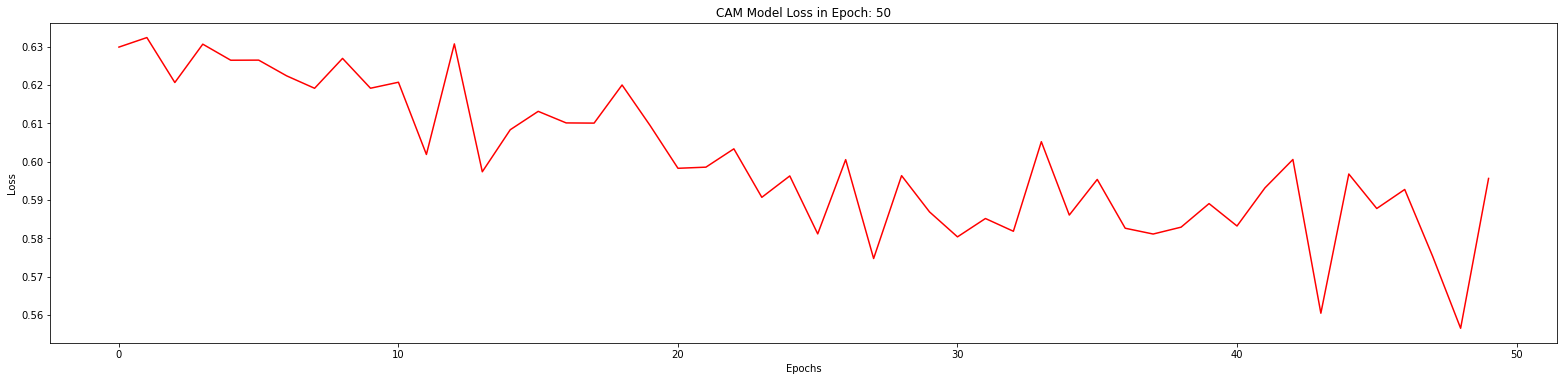

Epoch: 051, CAM Model Loss: 0.5550
Epoch: 052, CAM Model Loss: 0.5431
Epoch: 053, CAM Model Loss: 0.5483
Epoch: 054, CAM Model Loss: 0.5706
Epoch: 055, CAM Model Loss: 0.5652
Epoch: 056, CAM Model Loss: 0.5832
Epoch: 057, CAM Model Loss: 0.5866
Epoch: 058, CAM Model Loss: 0.5700
Epoch: 059, CAM Model Loss: 0.5583
Epoch: 060, CAM Model Loss: 0.5396
Epoch: 061, CAM Model Loss: 0.5578
Epoch: 062, CAM Model Loss: 0.5518
Epoch: 063, CAM Model Loss: 0.5473
Epoch: 064, CAM Model Loss: 0.5377
Epoch: 065, CAM Model Loss: 0.5287
Epoch: 066, CAM Model Loss: 0.5488
Epoch: 067, CAM Model Loss: 0.5439
Epoch: 068, CAM Model Loss: 0.5372
Epoch: 069, CAM Model Loss: 0.5470
Epoch: 070, CAM Model Loss: 0.5470
Epoch: 071, CAM Model Loss: 0.5258
Epoch: 072, CAM Model Loss: 0.5413
Epoch: 073, CAM Model Loss: 0.5316
Epoch: 074, CAM Model Loss: 0.5257
Epoch: 075, CAM Model Loss: 0.5331
Epoch: 076, CAM Model Loss: 0.5225
Epoch: 077, CAM Model Loss: 0.5480
Epoch: 078, CAM Model Loss: 0.5445
Epoch: 079, CAM Mode

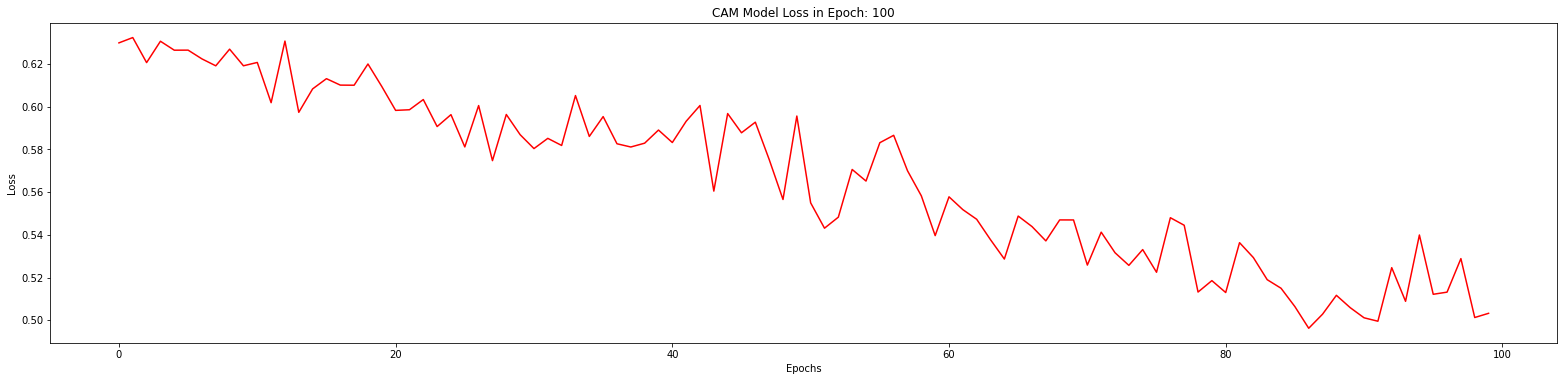

Epoch: 101, CAM Model Loss: 0.5426
Epoch: 102, CAM Model Loss: 0.5232
Epoch: 103, CAM Model Loss: 0.5051
Epoch: 104, CAM Model Loss: 0.4808
Epoch: 105, CAM Model Loss: 0.5046
Epoch: 106, CAM Model Loss: 0.5123
Epoch: 107, CAM Model Loss: 0.5121
Epoch: 108, CAM Model Loss: 0.5224
Epoch: 109, CAM Model Loss: 0.4991
Epoch: 110, CAM Model Loss: 0.5250
Epoch: 111, CAM Model Loss: 0.4819
Epoch: 112, CAM Model Loss: 0.4929
Epoch: 113, CAM Model Loss: 0.4920
Epoch: 114, CAM Model Loss: 0.4951
Epoch: 115, CAM Model Loss: 0.4869
Epoch: 116, CAM Model Loss: 0.5232
Epoch: 117, CAM Model Loss: 0.5003
Epoch: 118, CAM Model Loss: 0.5306
Epoch: 119, CAM Model Loss: 0.4968
Epoch: 120, CAM Model Loss: 0.5220
Epoch: 121, CAM Model Loss: 0.4868
Epoch: 122, CAM Model Loss: 0.5526
Epoch: 123, CAM Model Loss: 0.4816
Epoch: 124, CAM Model Loss: 0.5072
Epoch: 125, CAM Model Loss: 0.5103
Epoch: 126, CAM Model Loss: 0.4805
Epoch: 127, CAM Model Loss: 0.4958
Epoch: 128, CAM Model Loss: 0.5065
Epoch: 129, CAM Mode

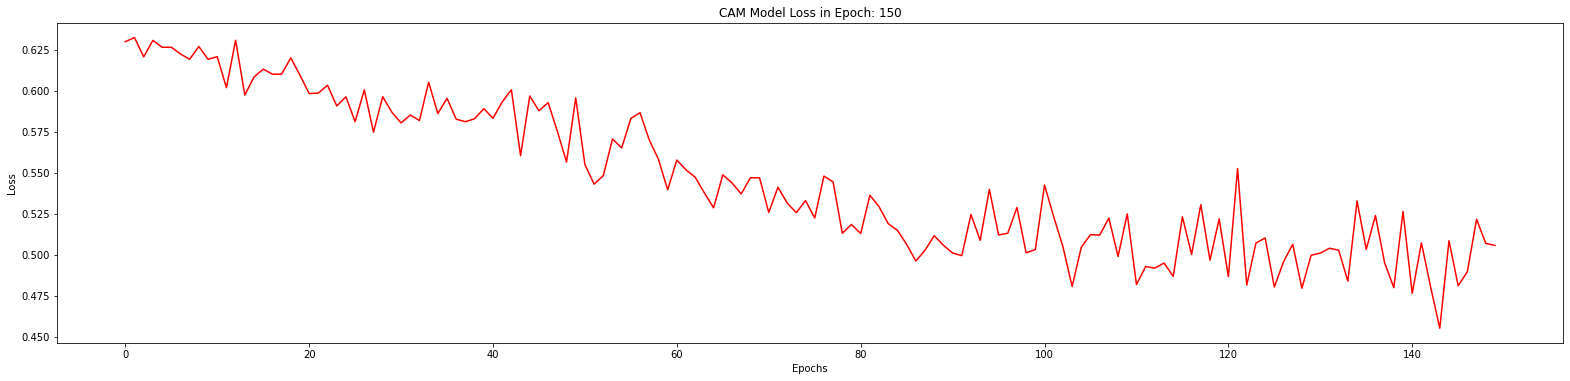

Epoch: 151, CAM Model Loss: 0.4964
Epoch: 152, CAM Model Loss: 0.4821
Epoch: 153, CAM Model Loss: 0.4849
Epoch: 154, CAM Model Loss: 0.4845
Epoch: 155, CAM Model Loss: 0.5021
Epoch: 156, CAM Model Loss: 0.4503
Epoch: 157, CAM Model Loss: 0.5071
Epoch: 158, CAM Model Loss: 0.4751
Epoch: 159, CAM Model Loss: 0.4913
Epoch: 160, CAM Model Loss: 0.4849
Epoch: 161, CAM Model Loss: 0.4813
Epoch: 162, CAM Model Loss: 0.5341
Epoch: 163, CAM Model Loss: 0.5024
Epoch: 164, CAM Model Loss: 0.5163
Epoch: 165, CAM Model Loss: 0.4758
Epoch: 166, CAM Model Loss: 0.5032
Epoch: 167, CAM Model Loss: 0.4728
Epoch: 168, CAM Model Loss: 0.4537
Epoch: 169, CAM Model Loss: 0.5186
Epoch: 170, CAM Model Loss: 0.4915
Epoch: 171, CAM Model Loss: 0.4904
Epoch: 172, CAM Model Loss: 0.4825
Epoch: 173, CAM Model Loss: 0.4940
Epoch: 174, CAM Model Loss: 0.5240
Epoch: 175, CAM Model Loss: 0.4704
Epoch: 176, CAM Model Loss: 0.4604
Epoch: 177, CAM Model Loss: 0.4748
Epoch: 178, CAM Model Loss: 0.4877
Epoch: 179, CAM Mode

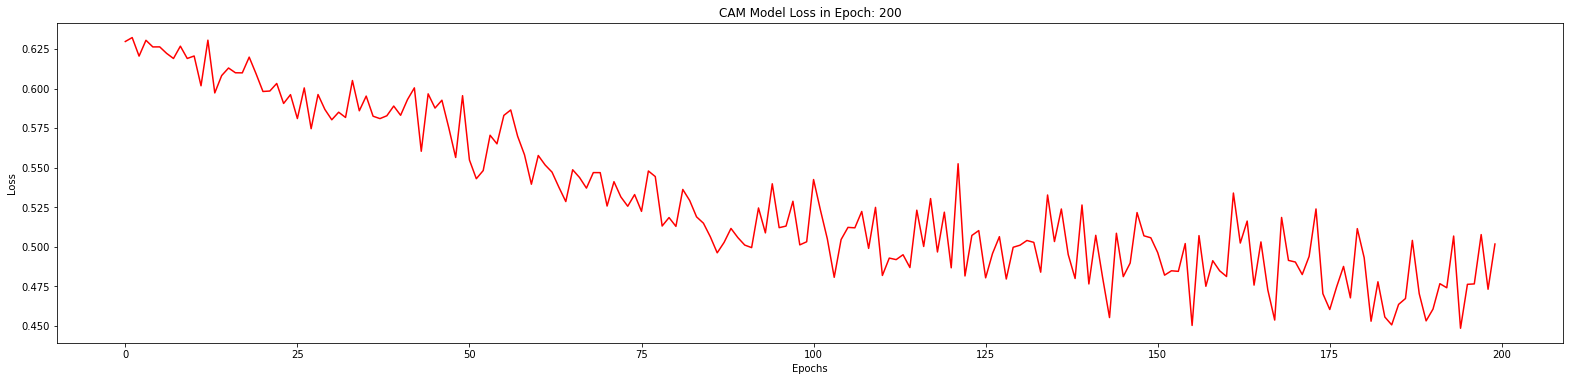

In [23]:
EPOCHS = 200
load_index = 0
if load_index is not 0:
  model_GCN, optimizer, load_index = loading_model(load_index)
train(EPOCHS, load_index)

# **Test Configuration for the Model**

In [24]:
def CAM_test(test_loader):
  predictions = []
  CAM_model_GCN.eval()
  correct = 0
  for batched_data in test_loader:  
    CAM_Test_One_Before_Last_Conv, CAM_Test_Last_Conv, CAM_Test_GAP, CAM_test_out = CAM_model_GCN(batched_data.x, batched_data.edge_index, batched_data.batch)  
    CAM_test_pred = CAM_test_out.argmax(dim=1) 
    predictions.append(CAM_test_pred)  
    #print(CAM_test_pred) 
    correct += int((CAM_test_pred == batched_data.y).sum())  
  return correct / len(test_loader.dataset), predictions[0].detach().tolist()

In [25]:
CAM_test_acc, predictions = CAM_test(test_loader)
print(f'Test Accuracy: {CAM_test_acc:.4f}')

Test Accuracy: 0.5789


In [26]:
print(predictions)
real_labels = []
for graph in test_dataset:
  real_labels.append(graph.y.detach().tolist()[0])
print(real_labels)

[1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1]
[1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1]


In [27]:
Auc_Roc = metrics.roc_auc_score(real_labels, predictions)
precision, recall, thresholds = metrics.precision_recall_curve(real_labels, predictions)
Auc_Prc = metrics.auc(y=precision, x=recall)
Acc = metrics.accuracy_score(real_labels, predictions, normalize=True)
Acc2 = metrics.accuracy_score(real_labels, predictions, normalize=False)
print(Auc_Roc, Auc_Prc, Acc, Acc2)

0.5327380952380952 0.7731950067476383 0.5789473684210527 22


## **Instance Specific Time**

In [28]:
def instance_time(test_dataset):
  instance_based_time = []
  CAM_model_GCN.eval()
  correct = 0
  for batched_data in test_dataset:
    start_generation = perf_counter()
    post_conv1, post_conv2, out_readout, CAM_test_out = CAM_model_GCN(batched_data.x, batched_data.edge_index, batched_data.batch)  
    CAM_test_pred = CAM_test_out.argmax(dim=1)
    consumed_time = perf_counter() - start_generation
    instance_based_time.append(consumed_time)    
  return instance_based_time

In [29]:
times = instance_time(test_dataset)
print(f'Test Instance based Time: {times}')

Test Instance based Time: [0.00696838400000388, 0.0015181130000030407, 0.0011441999999988184, 0.0012482320000231084, 0.0014902570000003834, 0.0021378239999876314, 0.001936011999987386, 0.0009732390000181113, 0.000985429999985854, 0.0011157830000172453, 0.0009617310000180623, 0.0009657390000086252, 0.0009064850000015667, 0.000860926999990852, 0.00089914300002647, 0.0008836039999948753, 0.0009048740000139333, 0.0008892369999955463, 0.0009245200000123077, 0.0008959289999950215, 0.0008860019999872293, 0.0008805410000150005, 0.0008564950000220506, 0.0008834409999849413, 0.0009729040000081568, 0.0009012529999949948, 0.0009220759999948314, 0.0009347269999864238, 0.0008891790000120636, 0.0008927840000012566, 0.0008919670000011592, 0.000935864999974001, 0.0009142030000077739, 0.000849866999999449, 0.0008868479999932788, 0.0008800789999838798, 0.0009024689999819202, 0.0008915959999740153]


# **CAM Function**

In [ ]:
import cv2
def return_CAM(feature_conv, weight, class_idx):
    # generate the class -activation maps upsample to 256x256
    size_upsample = (256, 256)
    bz, nc, h, w = feature_conv.shape
    output_cam = []
    for idx in class_idx:
        beforeDot =  feature_conv.reshape((nc, h*w))
        cam = np.matmul(weight[idx], beforeDot)
        cam = cam.reshape(h, w)
        cam = cam - np.min(cam)
        cam_img = cam / np.max(cam)
        cam_img = np.uint8(255 * cam_img)
        output_cam.append(cv2.resize(cam_img, size_upsample))
    return output_cam

# **Weights of The Trained Model old way**

In [ ]:
parameters_of_the_Model = list(GCN(size_of_hidden_layers).parameters())
weights_last_layer = np.squeeze(parameters_of_the_Model[-2].data.numpy())

In [ ]:
print(weights_last_layer)

[[ 0.23130195  0.11874456 -0.20962878  0.12244625 -0.1802125  -0.30890152
   0.34350663]
 [ 0.2729846  -0.1260498   0.19975416 -0.00455147  0.13570432 -0.00249507
   0.30220422]]


In [ ]:
print(CAM_model_GCN.conv1)
StateDict = CAM_model_GCN.state_dict()
print(StateDict.keys())
whole_weights = StateDict.items()
#print(whole_weights)


Conv1_biases = StateDict.get('conv1.bias')
Conv1_Weights = StateDict.get('conv1.lin.weight')

Conv2_biases = StateDict.get('conv2.bias')
Conv2_Weights = StateDict.get('conv2.lin.weight')

Conv3_biases = StateDict.get('conv3.bias')
Conv3_Weights = StateDict.get('conv3.lin.weight')

Dense_biases = StateDict.get('lin.bias')
Dense_Weights = StateDict.get('lin.weight')

print(f'Length of CONV1_Weights: {len(Conv1_Weights)}')
print(f'Length of CONV1.Bias: {len(Conv1_biases)}')

print(f'Length of CONV2_Weights: {len(Conv2_Weights)}')
print(f'Length of CONV2.Bias: {len(Conv2_biases)}')

print(f'Length of CONV3_Weights: {len(Conv3_Weights)}')
print(f'Length of CONV3.Bias: {len(Conv3_biases)}')

print(f'Length of Dense_Weights: {len(Dense_Weights)}')
print(f'Length of Dense.Bias: {len(Dense_biases)}')


GCNConv(7, 7)
odict_keys(['conv1.bias', 'conv1.lin.weight', 'conv2.bias', 'conv2.lin.weight', 'conv3.bias', 'conv3.lin.weight', 'lin.weight', 'lin.bias'])
Length of CONV1_Weights: 7
Length of CONV1.Bias: 7
Length of CONV2_Weights: 7
Length of CONV2.Bias: 7
Length of CONV3_Weights: 7
Length of CONV3.Bias: 7
Length of Dense_Weights: 2
Length of Dense.Bias: 2


In [ ]:
print(Dense_Weights)

tensor([[-0.6171, -1.2386, -1.1665,  0.0028,  0.5823, -0.3089,  0.2240],
        [ 1.1214,  1.2313,  1.1566,  0.1151, -0.6268, -0.0025,  0.4217]])


In [ ]:
x = CAM_model_GCN.lin.weight.data
y = CAM_model_GCN.conv3.lin.weight.data
print(x)
print(y)

tensor([[-0.6171, -1.2386, -1.1665,  0.0028,  0.5823, -0.3089,  0.2240],
        [ 1.1214,  1.2313,  1.1566,  0.1151, -0.6268, -0.0025,  0.4217]])
tensor([[-0.8821,  0.6278,  0.5252, -0.0812,  1.1155, -0.6077, -0.1002],
        [-0.9160,  1.1913,  0.1381, -0.1343,  1.6135,  0.3922, -0.1622],
        [-1.0861,  1.4106, -0.1843,  0.0706,  1.4235,  0.3077, -0.2533],
        [-0.0686, -0.0387,  0.3147, -0.3112, -0.4407, -0.4616,  0.4783],
        [ 0.5834,  0.4399, -0.5563, -0.5487,  0.5575, -0.2737, -0.1652],
        [-0.5588, -0.1911, -0.1283, -0.4988, -0.2494, -0.2130,  0.5838],
        [-0.2941, -0.2646,  0.4248, -0.4193,  0.0661, -0.3087,  0.2678]])


## **Weights of the Model**

In [30]:
def weights_of_model(model):
  Dense_Layer_Weights = model.ffn.weight
  #Dense_Layer_Biases = model.lin.bias.data

  #GConv3_Layer_Weights = model.conv3.lin.weight.data
  GConv2_Layer_Weights = model.gconv2.weight
  GConv1_Layer_Weights = model.gconv1.weight

  Dense_Layer_Weights = Dense_Layer_Weights.detach().tolist()
  #GConv3_Layer_Weights = GConv3_Layer_Weights.detach().tolist()
  GConv2_Layer_Weights = GConv2_Layer_Weights.detach().tolist()
  GConv1_Layer_Weights = GConv1_Layer_Weights.detach().tolist()

  #return GConv1_Layer_Weights, GConv2_Layer_Weights, GConv3_Layer_Weights, Dense_Layer_Weights
  return GConv1_Layer_Weights, GConv2_Layer_Weights, Dense_Layer_Weights

In [31]:
GConv1_Layer_Weights, GConv2_Layer_Weights, Dense_Layer_Weights = weights_of_model(CAM_model_GCN)

In [32]:
print(np.shape(GConv1_Layer_Weights))
print(np.shape(GConv2_Layer_Weights))
#print(np.shape(GConv3_Layer_Weights))
print(np.shape(Dense_Layer_Weights))

(7, 7)
(7, 7)
(2, 7)


# **Feature MAPs**

In [33]:
def CAM_FeatureMAP_production(test_loader):
  index_of_winner_labels = []
  FeatureMaps_of_the_Last_Conv = []
  output_of_the_GAP = []
  Final_predictions = []

  CAM_model_GCN.eval()
  for batched_data in test_loader:  
    CAM_Test_One_Before_Last_Conv, CAM_Test_Last_Conv, CAM_Test_GAP, CAM_output = CAM_model_GCN(batched_data.x, batched_data.edge_index, batched_data.batch)
    #index_of_winner_label = CAM_output.argmax(dim=1) 
    logits = F.log_softmax(CAM_output, dim=1)
    prob = F.softmax(logits, dim=1)
    index_of_winner_label = prob.argmax(dim=1) 

    index_of_winner_labels.append(index_of_winner_label.detach().tolist()) 
    Final_predictions.append(prob.detach().tolist())
    output_of_the_GAP.append(CAM_Test_GAP.detach().tolist())
    FeatureMaps_of_the_Last_Conv.append(CAM_Test_Last_Conv.detach().tolist())
  return FeatureMaps_of_the_Last_Conv, output_of_the_GAP, Final_predictions, index_of_winner_labels

In [34]:
FeatureMaps_of_the_Last_Conv, output_of_the_GAP, Final_predictions, index_of_winner_labels = CAM_FeatureMAP_production(test_dataset)

In [ ]:
#FeatureMaps_of_the_Last_Conv = FeatureMaps_of_the_Last_Conv.detach().numpy()
#output_of_the_GAP = torch.stack(output_of_the_GAP).cpu().detach().numpy()
#Final_predictions = torch.stack(Final_predictions).cpu().detach().numpy()
#Dense_Weights = Dense_Weights.detach().numpy()
#Dense_Weights = Dense_Weights.tolist()
#index_list = index_list.detach().numpy()
#index_of_winner_labels = index_of_winner_labels.tolist()
#FeatureMaps_of_the_Last_Conv = FeatureMaps_of_the_Last_Conv.tolist()


In [35]:
#print(FeatureMaps_of_the_Last_Conv)
print(len(FeatureMaps_of_the_Last_Conv[0]))
print(np.shape(FeatureMaps_of_the_Last_Conv))
print(np.shape(output_of_the_GAP))
print(np.shape(Final_predictions))
print(Final_predictions)
print(index_of_winner_labels)

17
(38,)
(38, 1, 7)
(38, 1, 2)
[[[0.1310814470052719, 0.8689185976982117]], [[0.435930460691452, 0.5640695095062256]], [[0.43807175755500793, 0.5619282126426697]], [[0.7991008758544922, 0.20089907944202423]], [[0.20545658469200134, 0.7945433855056763]], [[0.26586687564849854, 0.7341331243515015]], [[0.22074179351329803, 0.7792582511901855]], [[0.16241863369941711, 0.8375813961029053]], [[0.13087721168994904, 0.8691228032112122]], [[0.15012452006340027, 0.8498755097389221]], [[0.5734042525291443, 0.4265957176685333]], [[0.4521279036998749, 0.5478721261024475]], [[0.5692689418792725, 0.4307311177253723]], [[0.13979411125183105, 0.860205888748169]], [[0.0995057001709938, 0.9004943370819092]], [[0.682847797870636, 0.3171522319316864]], [[0.14068296551704407, 0.8593170046806335]], [[0.3372936546802521, 0.6627063751220703]], [[0.3062729239463806, 0.6937270760536194]], [[0.09873995929956436, 0.9012600779533386]], [[0.4470541775226593, 0.5529457926750183]], [[0.2899724543094635, 0.710027575492

/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


In [ ]:
#FeatureMaps_of_the_Last_Conv = FeatureMaps_of_the_Last_Conv[0].copy()

# **Weights W.R.T...**

In [36]:
def weight_wrt_class_and_performance(index_of_winner_labels, Dense_Layer_Weights):
  Weights_of_the_Predicted_Class = []
  for i in range(len(index_of_winner_labels)):
    Weights_of_the_Predicted_Class.append(Dense_Layer_Weights[index_of_winner_labels[i][0]])
  
  Weights_of_the_Class_0 = []
  for i in range(len(index_of_winner_labels)):
    Weights_of_the_Class_0.append(Dense_Layer_Weights[0])

  Weights_of_the_Class_1 = []
  for i in range(len(index_of_winner_labels)):
    Weights_of_the_Class_1.append(Dense_Layer_Weights[1])

  return Weights_of_the_Predicted_Class, Weights_of_the_Class_0, Weights_of_the_Class_1

In [37]:
Weights_of_the_Predicted_Class, Weights_of_the_Class_0, Weights_of_the_Class_1 = weight_wrt_class_and_performance(index_of_winner_labels, Dense_Layer_Weights)

In [38]:
print(np.shape(Weights_of_the_Predicted_Class))
print(np.shape(Weights_of_the_Class_0))
print(np.shape(Weights_of_the_Class_1))

(38, 7)
(38, 7)
(38, 7)


In [39]:
print(np.shape(Weights_of_the_Predicted_Class))
print(np.shape(FeatureMaps_of_the_Last_Conv))

(38, 7)
(38,)


In [ ]:
#Feature_Maps_of_the_Last_Conv = []
#for i in range(len(test_dataset)):
#  Feature_Maps_of_the_Last_Conv.append(FeatureMaps_of_the_Last_Conv[0:test_dataset[i].num_nodes])
#  FeatureMaps_of_the_Last_Conv = FeatureMaps_of_the_Last_Conv[test_dataset[i].num_nodes:]

In [40]:
print(len(FeatureMaps_of_the_Last_Conv))
print(np.shape(FeatureMaps_of_the_Last_Conv))
print(len(test_dataset))

#for i in range(len(test_dataset)):
#  print(test_dataset[i].num_nodes, len(Feature_Maps_of_the_Last_Conv[i]))

38
(38,)
38


# **Attribution of Weights and Maps**

In [41]:
def CAM_Attribution_Scores(weights, feat_maps):
  Weights_and_Maps_Multiplication_on_Nodes_of_each_graph = []
  Normalized_Attributions = []

  for i in range(len(feat_maps)):
    Each_Graph = []
    for j in range(len(feat_maps[i])):
      Each_Graph.append(np.multiply(weights[i], feat_maps[i][j]))
    Weights_and_Maps_Multiplication_on_Nodes_of_each_graph.append(Each_Graph)

  for i in range(len(feat_maps)):
    Each_Graph = []
    for j in range(len(feat_maps[i])):
      Each_Graph.append(sum(Weights_and_Maps_Multiplication_on_Nodes_of_each_graph[i][j]))
    norm = [(float(i))/(max(Each_Graph) + 1e-16) for i in Each_Graph] 
    Normalized_Attributions.append(norm)
  return Normalized_Attributions

In [42]:
atts = CAM_Attribution_Scores(Weights_of_the_Predicted_Class, FeatureMaps_of_the_Last_Conv)

In [43]:
print(atts[0][0])

0.9141845289822843


## **Fidelity**

In [44]:
def Compute_ROC_AUC(your_model, your_dataset):
  preds = []
  reals = []
  #print(len(your_dataset))
  num_classes = 2
  
  if num_classes > 2:
    print("Fidelity is only for Binaryclassification")
    return 0
    
  your_model.eval()
  for batched_data in your_dataset:
    CAM_Test_One_Before_Last_Conv, CAM_Test_Last_Conv, CAM_Test_GAP, CAM_output = your_model(batched_data.x, batched_data.edge_index, batched_data.batch)
    logits = F.log_softmax(CAM_output, dim=1)
    prob = F.softmax(logits, dim=1)
    
    preds.append(prob.cpu().detach())
    
  for i in range(len(your_dataset)):
    reals.append(your_dataset[i].y.cpu().detach().tolist())  
  preds = torch.cat(preds).cpu().numpy()
  preds = preds[:, 1]

  
  roc_auc = metrics.roc_auc_score(reals, preds, average='macro')
  return roc_auc

In [45]:
def is_salient(score, importance_range):
	start, end = importance_range
	if start <= score <= end:
		return True
	else:
		return False

In [46]:
def drop_important_nodes(your_dataset, importance_range, weights, feat_maps):
  CAM_attribution_scores = CAM_Attribution_Scores(weights, feat_maps)
  occluded_GNNgraph_list = []
  
  for i in range(len(CAM_attribution_scores)):
    sample_graph = deepcopy(your_dataset[i])
    for j in range(len(sample_graph.x)):
      
      if is_salient((CAM_attribution_scores[i][j]), importance_range):
        #print("before: ", sample_graph.x[j])
        sample_graph.x[j][:] = 0
        #print(torch.zeros_like(sample_graph.x[j]))
        #print("manipulated: ",sample_graph.x[j])
    occluded_GNNgraph_list.append(sample_graph)
  return occluded_GNNgraph_list

In [47]:
def Fidelity(your_model, your_dataset, weights, feat_maps, importance_range):

  auc_roc_before_droping_important_nodes = Compute_ROC_AUC(your_model, your_dataset)
  new_graph_dataset = drop_important_nodes(your_dataset, importance_range, weights, feat_maps)
  auc_roc_after_droping_important_nodes = Compute_ROC_AUC(your_model, new_graph_dataset)

  return auc_roc_after_droping_important_nodes - auc_roc_before_droping_important_nodes

## **Contrastivity**

In [48]:
def binarize_scores(weights, feat_maps, importance_range):
  CAM_attribution_scores = CAM_Attribution_Scores(weights, feat_maps)
  binarized_attribution_scores_list = []
  for scores in CAM_attribution_scores:
    binary_score = ''
    for score in scores:
      if is_salient(abs(float(score)), importance_range):
        binary_score += '1'
      else:
        binary_score += '0'
    binarized_attribution_scores_list.append(binary_score)
  return binarized_attribution_scores_list

In [49]:
def compute_contrastivity(weights_class0, weights_class1, feat_maps, importance_range):
  binarized_salient_nodes_for_class0 = binarize_scores(weights_class0, feat_maps, importance_range)
  binarized_salient_nodes_for_class1 = binarize_scores(weights_class1, feat_maps, importance_range)

  result_list = []
	# Calculate hamming distance
  for class_0, class_1 in zip(binarized_salient_nodes_for_class0, binarized_salient_nodes_for_class1):
    assert len(class_0) == len(class_1)
    d = hamming(class_0, class_1)
    result_list.append(d / len(class_0))
    
  return sum(result_list) / len(result_list)

## **Sparsity**

In [50]:
def binarize_nodes(weights_class0, weights_class1, weights_preds, feat_maps, importance_range):
  CAM_attribution_scores_class0 = CAM_Attribution_Scores(weights_class0, feat_maps)
  CAM_attribution_scores_class1 = CAM_Attribution_Scores(weights_class1, feat_maps)
  CAM_attribution_scores_graph = CAM_Attribution_Scores(weights_preds, feat_maps)

  class_0_salient_nodes = []
  class_1_salient_nodes = []
  salient_nodes_preds = []
  
  for i in range(len(CAM_attribution_scores_class0)):
      class_0_graph = []
      for j in range(len(CAM_attribution_scores_class0[i])):
        if is_salient((CAM_attribution_scores_class0[i][j]), importance_range):
          class_0_graph.append(1)
        else:
          class_0_graph.append(0)
      class_0_salient_nodes.append(class_0_graph)

  for i in range(len(CAM_attribution_scores_class1)):
      class_1_graph = []
      for j in range(len(CAM_attribution_scores_class1[i])):
        if is_salient((CAM_attribution_scores_class1[i][j]), importance_range):
          class_1_graph.append(1)
        else:
          class_1_graph.append(0)
      class_1_salient_nodes.append(class_1_graph)

  for i in range(len(CAM_attribution_scores_graph)):
      class_graph = []
      for j in range(len(CAM_attribution_scores_graph[i])):
        if is_salient((CAM_attribution_scores_graph[i][j]), importance_range):
          class_graph.append(1)
        else:
          class_graph.append(0)
      salient_nodes_preds.append(class_graph)

  return salient_nodes_preds, class_0_salient_nodes, class_1_salient_nodes

In [51]:
def count_important_nodes(salient_list):
  return sum(salient_list)

In [52]:
def compute_sparsity(feat_maps, weights_preds, weights_class0, weights_class1, importance_range):
  salient_nodes_preds, class_0_salient_nodes, class_1_salient_nodes = binarize_nodes(weights_class0, weights_class1, weights_preds, feat_maps, importance_range)
  #print(salient_nodes_graph)
  #print(class_0_salient_nodes)
  #print(class_1_salient_nodes)
  sparsity_list = []
  for i in range(len(salient_nodes_preds)):
    d = count_important_nodes(class_0_salient_nodes[i]) + count_important_nodes(class_1_salient_nodes[i])
    d = d / (len(salient_nodes_preds) * 2)
    sparsity_list.append(1 - d)
  return sum(sparsity_list) / len(sparsity_list)

## **Get Metrics**

In [53]:
def go_to_evaluations(your_model, dataset, importance_range):
  start_generation = perf_counter()

  GConv1_Layer_Weights, GConv2_Layer_Weights, Dense_Layer_Weights = weights_of_model(your_model)
  FeatureMaps_of_the_Last_Conv, output_of_the_GAP, Final_predictions, index_of_winner_labels = CAM_FeatureMAP_production(dataset)
  Weights_of_the_Predicted_Class, Weights_of_the_Class_0, Weights_of_the_Class_1 = weight_wrt_class_and_performance(index_of_winner_labels, Dense_Layer_Weights)
  CAM_Atts = CAM_Attribution_Scores(Weights_of_the_Predicted_Class, FeatureMaps_of_the_Last_Conv)
  
  time_consumption = perf_counter() - start_generation

  fid_cam_label = Fidelity(your_model, dataset, Weights_of_the_Predicted_Class, FeatureMaps_of_the_Last_Conv, importance_range)

  contrastivity_with_cam = compute_contrastivity(Weights_of_the_Class_0, Weights_of_the_Class_1, FeatureMaps_of_the_Last_Conv, importance_range)

  sparsity_with_cam = compute_sparsity(FeatureMaps_of_the_Last_Conv, Weights_of_the_Predicted_Class, Weights_of_the_Class_0, Weights_of_the_Class_1, importance_range)


  #.         ["Explicability Method Name", "DataSet", "Fidelity", "Contrastivity", "Sparsity", "Saliency Map Generation Time"]
  #with open("/content/drive/My Drive/Explainability Methods/Evaluation of Explicability Methods/Experimental Results/Comparisons ExMethods.csv", 'a') as outcsv:
  #  wr = csv.writer(outcsv, dialect='excel', delimiter=',')
  #  wr.writerow([str(Explainability_name), "MUTAG", fid_cam_label, contrastivity_with_cam, sparsity_with_cam, time_consumption])
  task_dict = {"Graph Classification": "GC", "Node Classification": "NC"}
  with open("/content/drive/My Drive/Explainability Methods/Evaluation of Explicability Methods/Experimental Results/Comparisons ExMethods for SoftWare.csv", 'a') as outcsv:
    wr = csv.writer(outcsv, dialect='excel', delimiter=',')
    wr.writerow([str(Explainability_name), task_dict[str(Task_name)], "MUTAG", "GCN+GAP", Auc_Roc, Auc_Prc, CAM_Model_training_Acc_per_epoch[-1], Acc, Acc2, fid_cam_label, contrastivity_with_cam, sparsity_with_cam, time_consumption, mean(CAM_Model_training_time_per_epoch), times])

  #return fid_cam_label, contrastivity_with_cam, sparsity_with_cam, time_consumption

In [54]:
#fid_cam_glabel, contrastivity_with_cam, sparsity_with_cam, time_consumption = go_to_evaluations(CAM_model_GCN, test_dataset, (0.5, 1))
go_to_evaluations(CAM_model_GCN, test_dataset, (0.5, 1))

In [ ]:
#print(fid_cam_glabel, contrastivity_with_cam, sparsity_with_cam, time_consumption)

# **Pointwise Average for each Graph**

In [ ]:
CAMs_AVG_for_each_Graph = []
for i in range(len(Weights_and_Maps_Multiplication_on_Nodes_of_each_graph)):
  CAMs_AVG_for_each_Graph.append(np.mean(Weights_and_Maps_Multiplication_on_Nodes_of_each_graph[i], axis=0))   # MEAN or ARGMAX then divide by counts of nodes in each GRAPH
print(np.shape(CAMs_AVG_for_each_Graph))

(38, 7)


# **Point-Wise Sum for each Graph**

In [ ]:
CAMs_SUM_for_each_Graph = []
for i in range(len(Weights_and_Maps_Multiplication_on_Nodes_of_each_graph)):
  sum = [0] * len(Weights_and_Maps_Multiplication_on_Nodes_of_each_graph[0][0])
  for j in range(len(Weights_and_Maps_Multiplication_on_Nodes_of_each_graph[i])):
    sum = list( map(add, sum, Weights_and_Maps_Multiplication_on_Nodes_of_each_graph[i][j]))
  CAMs_SUM_for_each_Graph.append(sum)

In [ ]:
print(np.shape(CAMs_SUM_for_each_Graph))
print(len(Weights_and_Maps_Multiplication_on_Nodes_of_each_graph[0]))
print(CAMs_AVG_for_each_Graph[0])
print(CAMs_SUM_for_each_Graph[0])

(38, 7)
28
[ 1.36272633  2.44386814  2.17782187  0.         -1.64666757  0.
  0.        ]
[38.15633737072264, 68.42830787437154, 60.97901244183305, 0.0, -46.10669198197817, 0.0, 0.0]


# **Plot Attributes of Each Graph (i.e., in SUM of its Nodes)**

In [ ]:
def visualize_CAMs(CAMs_Graphs, index, HIV_status):

  fig = plt.figure(figsize=(15,10))

  ax = plt.subplot2grid((3, 1), (0, 0), colspan=1)
  plt.xlabel('Attributes')
  plt.ylabel('CAMs; Weights & Feature Maps')
  plt.title("CAMs in Test Graph: " + str(index+1) + " whith " + str(HIV_status) + "status")

  ax.plot(CAMs_Graphs, color='r')

  plt.savefig('/content/drive/My Drive/'+str(Explainability_name)+' on ' + str(Task_name) + '/Experimental Results/'+'CAMs in Test Graph {:04d} with {} status.png'.format(index+1, HIV_status))
  plt.show() 

In [ ]:
HIV_POS = []
HIV_NEG = []

HIV_POS_index = []
HIV_NEG_index = []

for i, x in enumerate(CAMs_SUM_for_each_Graph):
  if index_list[i]:
    HIV_POS.append(x)
    HIV_POS_index.append(i)
  else:
    HIV_NEG.append(x)
    HIV_NEG_index.append(i)
print(len(HIV_POS))
print(len(HIV_NEG))

print(len(HIV_POS_index))
print(len(HIV_NEG_index))
print(index_list)
print(HIV_POS_index)
print(HIV_NEG_index)

27
11
27
11
[1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]
[0, 2, 3, 5, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 22, 23, 24, 27, 28, 29, 30, 32, 33, 34, 36, 37]
[1, 4, 6, 7, 13, 20, 21, 25, 26, 31, 35]


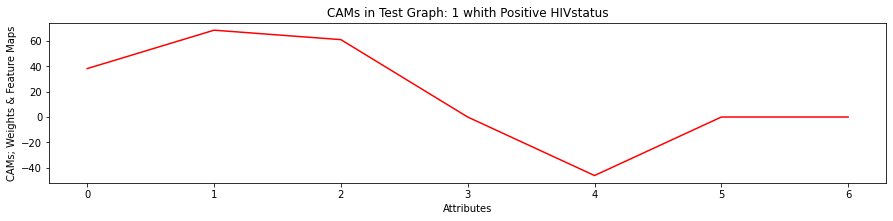

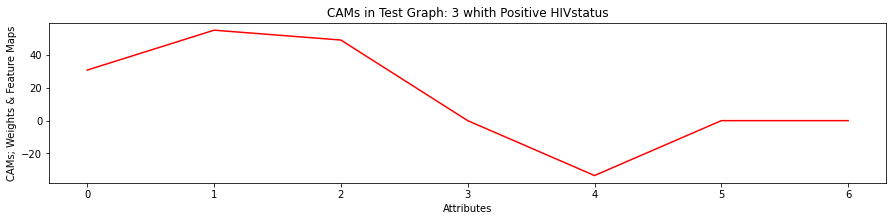

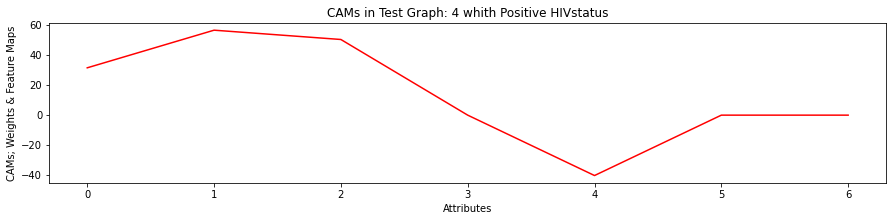

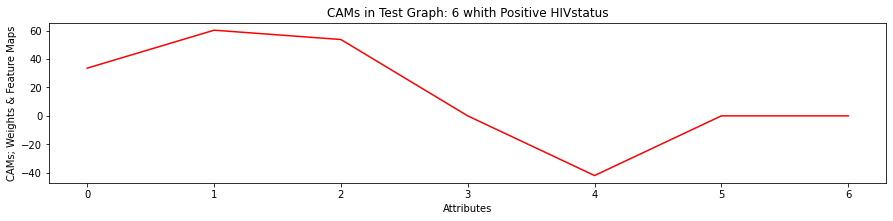

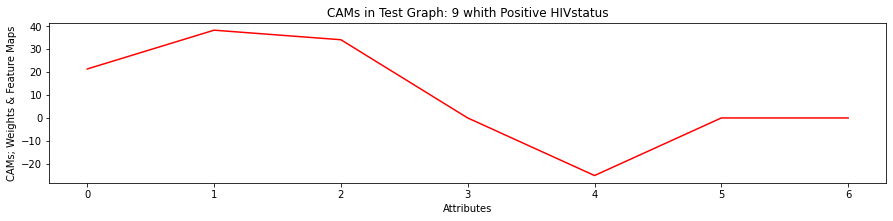

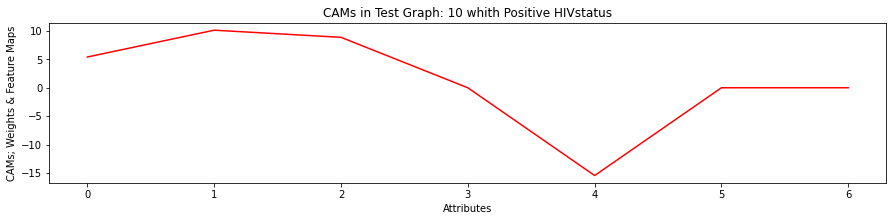

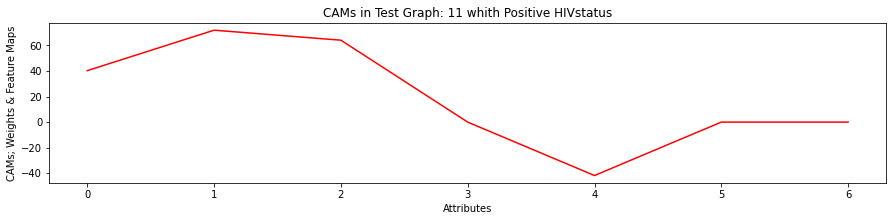

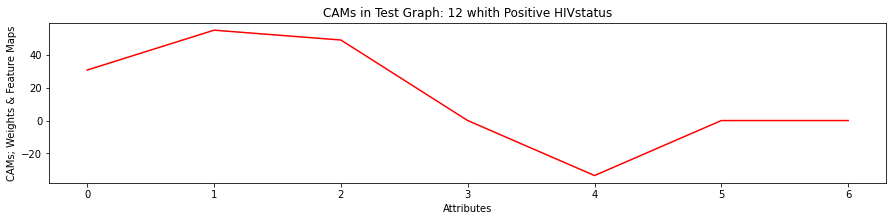

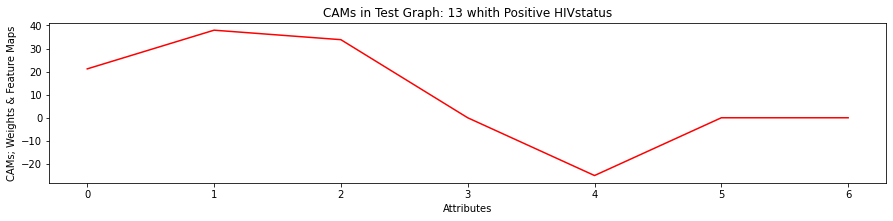

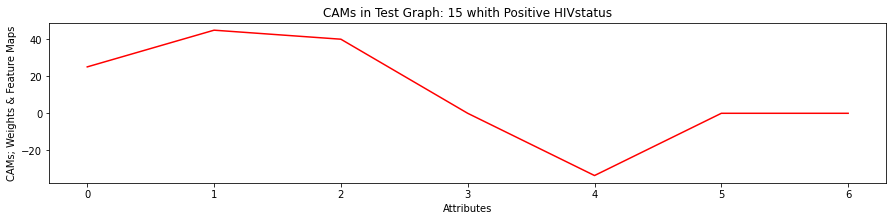

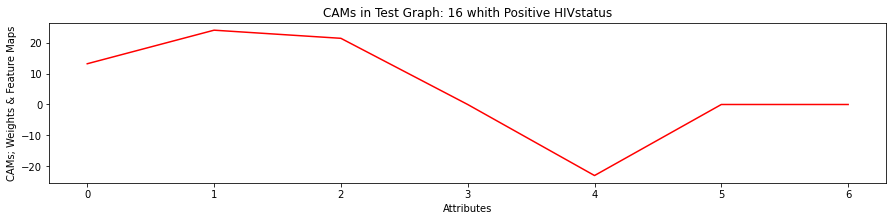

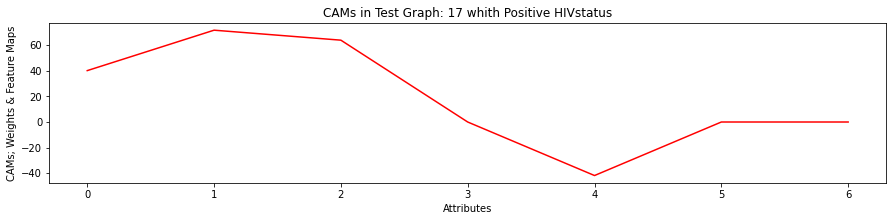

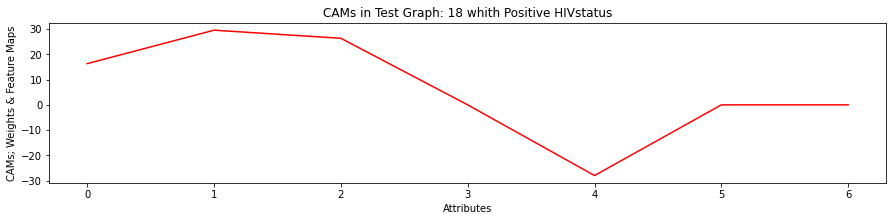

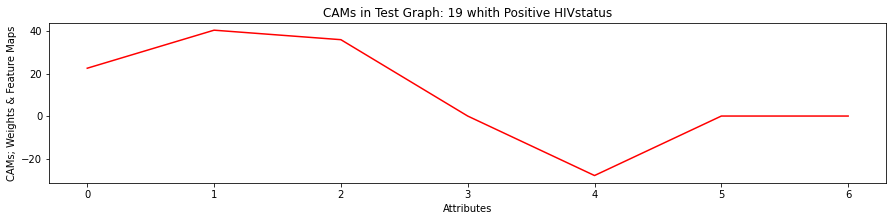

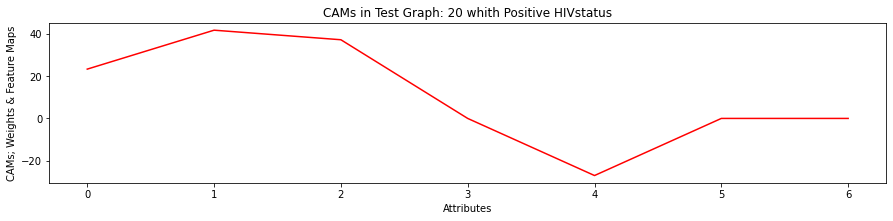

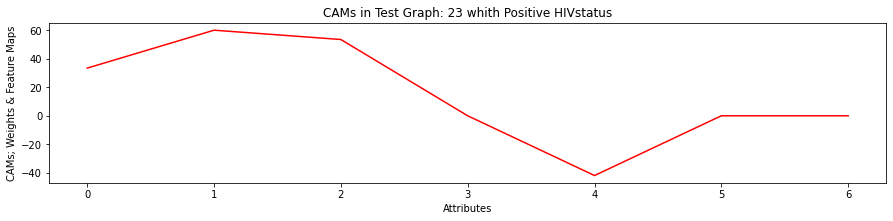

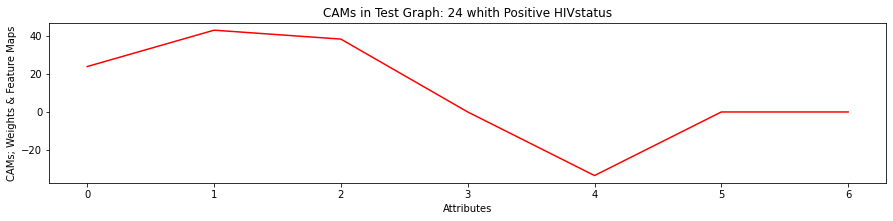

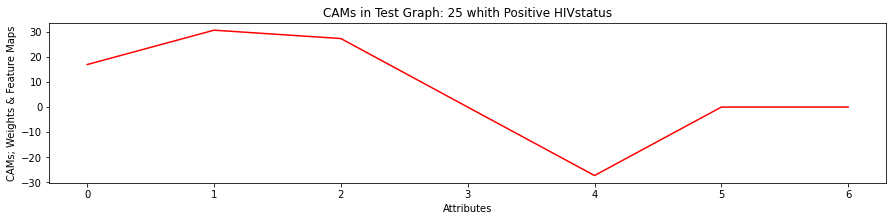

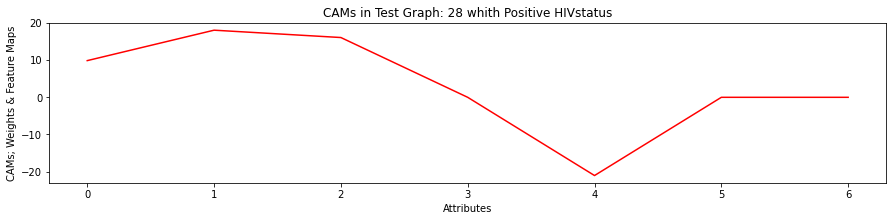

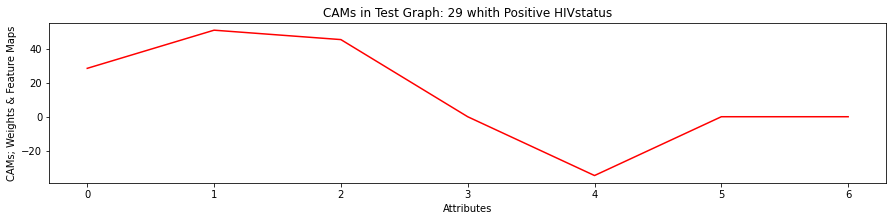

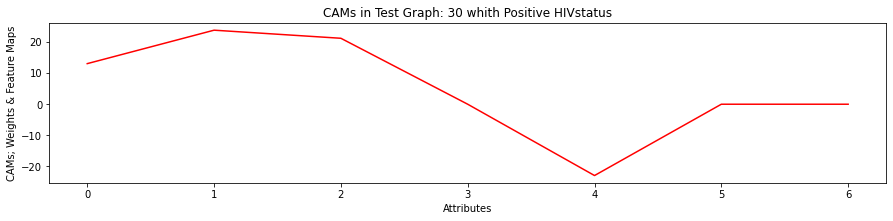

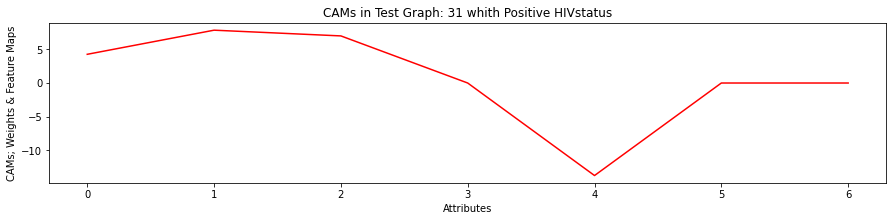

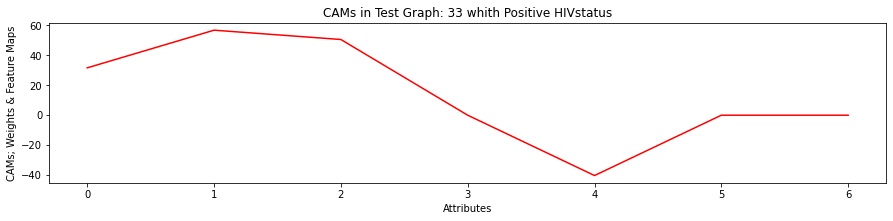

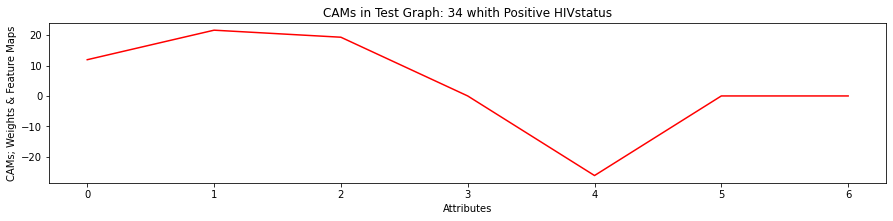

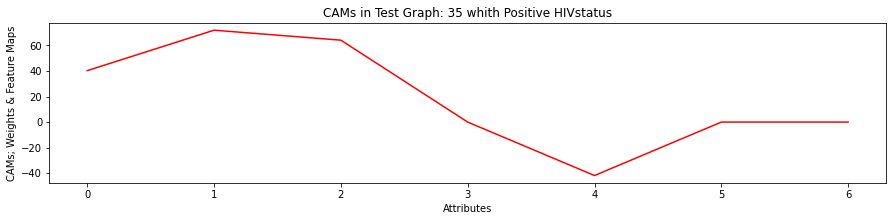

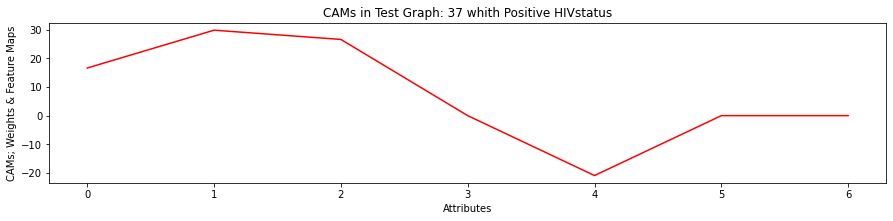

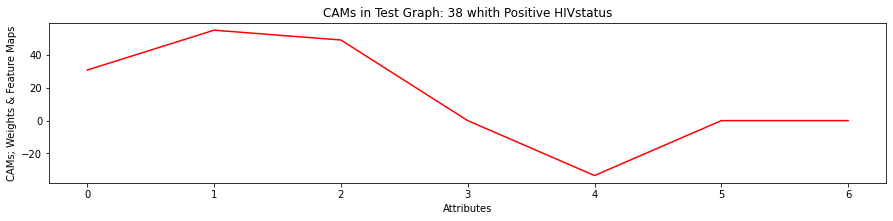

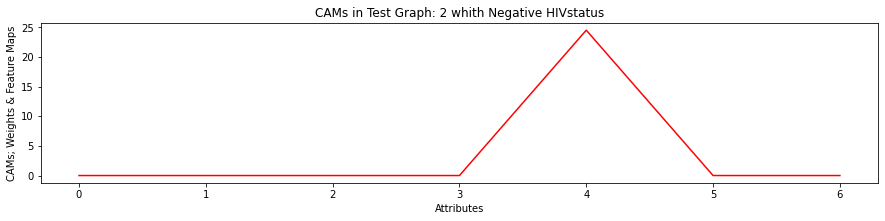

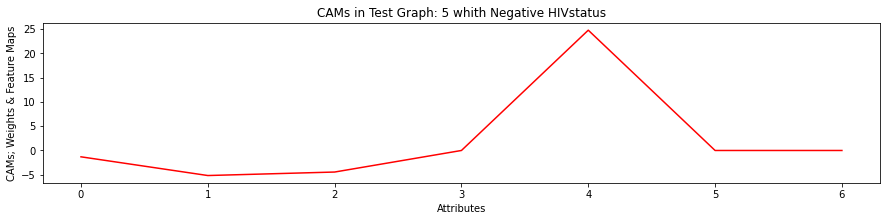

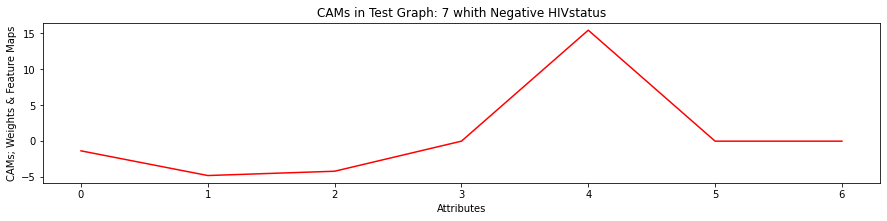

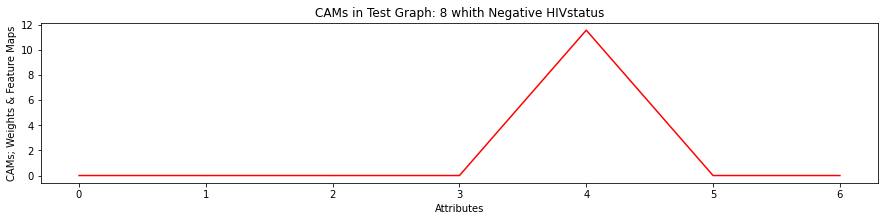

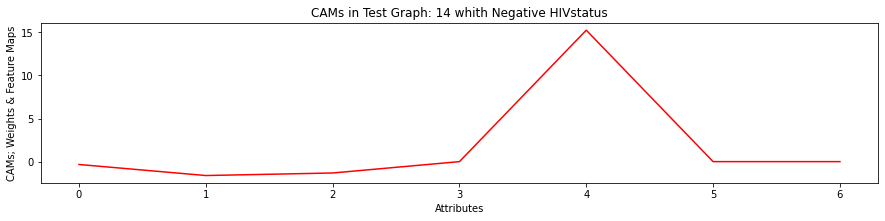

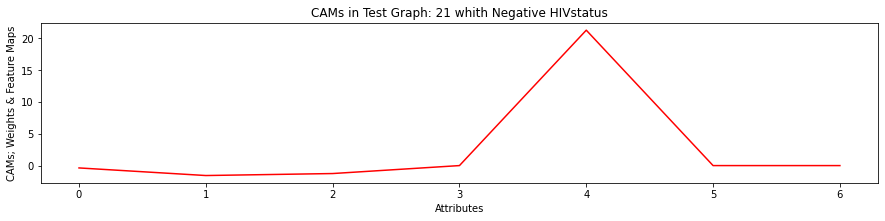

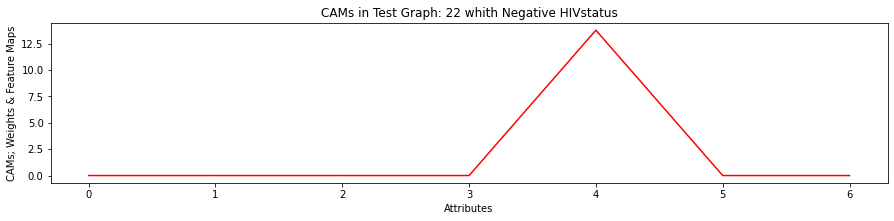

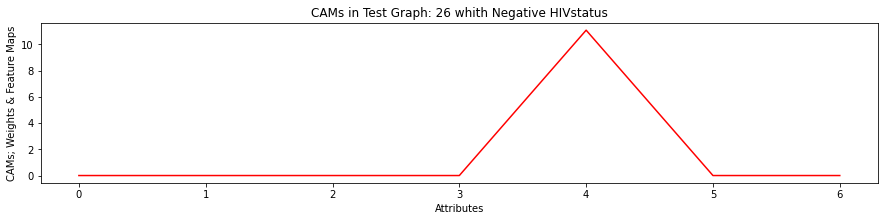

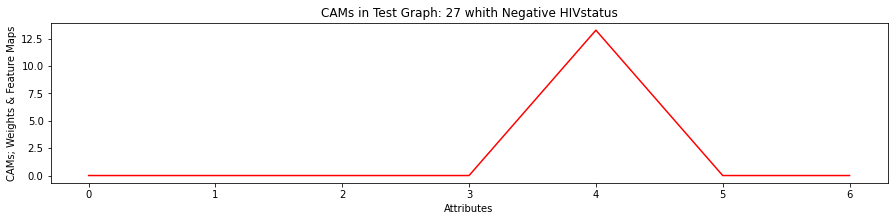

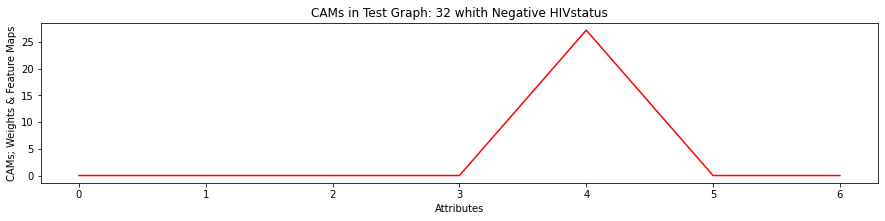

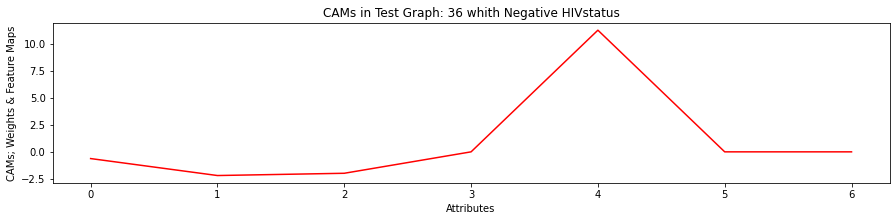

In [ ]:
HIV_status = "Positive HIV"
for i in range(len(HIV_POS)):
  visualize_CAMs(HIV_POS[i], HIV_POS_index[i], HIV_status)

HIV_status = "Negative HIV"
for i in range(len(HIV_NEG)):
  visualize_CAMs(HIV_NEG[i], HIV_NEG_index[i], HIV_status)

In [ ]:
#print(Weights_of_the_Winner_Node[0])
#print('***********************************')
#print(Feature_Maps_of_the_Last_Conv[0][0])
#print('===================================')
#print(CAMs_of_Nodes_for_each_graph[0][0])

In [ ]:
#print(np.shape(FeatureMaps_of_the_Last_Conv))
#for i in range(len(FeatureMaps_of_the_Last_Conv[0])):
#  print(FeatureMaps_of_the_Last_Conv[0][i])

In [ ]:
#CAM_model_GCN.eval()
#x = []
#for batched_data in test_dataset:  
#    Last_Conv, GAP, cam_preds = CAM_model_GCN(batched_data.x, batched_data.edge_index, batched_data.batch)
#    x.append(Last_Conv)

In [ ]:
#print('CAM_Test_Last_Conv')
#print(CAM_Test_Last_Conv)
#print("=========================================================================")
#print(len(x))

#summ = 0
#for i in range(len(x)):
#  print(len(x[i]), test_dataset[i].num_nodes)
#  summ=summ+len(x[i])
#print(summ)

# **Upto the last Conv layer**

# **Gradients of CAM**


In [ ]:
'''def accumulate_gradients(model_for_you):
  before_CAM = []
  after_CAM = []
  
  for name, param in model_for_you.named_parameters():

    if name == "conv1.bias":
      before_CAM.append(param.grad.detach().clone())
      param.grad = torch.square(param.grad)
      after_CAM.append(param.grad.detach().clone())
    if name == "conv1.lin.weight":
      before_CAM.append(param.grad.detach().clone())
      param.grad = torch.square(param.grad)
      after_CAM.append(param.grad.detach().clone())

    if name == "conv2.bias":
      before_CAM.append(param.grad.detach().clone())
      param.grad = torch.square(param.grad)
      after_CAM.append(param.grad.detach().clone())
    if name == "conv2.lin.weight":
      before_CAM.append(param.grad.detach().clone())
      param.grad = torch.square(param.grad)
      after_CAM.append(param.grad.detach().clone())

    if name == "conv3.bias":
      before_CAM.append(param.grad.detach().clone())
      param.grad = torch.square(param.grad)
      after_CAM.append(param.grad.detach().clone())
    if name == "conv3.lin.weight":
      before_CAM.append(param.grad.detach().clone())
      param.grad = torch.square(param.grad)
      after_CAM.append(param.grad.detach().clone())

    if name == "lin.bias":
      before_CAM.append(param.grad.detach().clone())
      param.grad = torch.square(param.grad)
      after_CAM.append(param.grad.detach().clone())
    if name == "lin.weight":
      before_CAM.append(param.grad.detach().clone())
      param.grad = torch.square(param.grad)
      after_CAM.append(param.grad.detach().clone())
  

  return before_CAM, after_CAM'''

In [ ]:
#holder_of_old_gradients, holder_of_new_gradients = accumulate_gradients(CAM_model_GCN)

In [ ]:
#print(len(holder_of_new_gradients))

8
